In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# home_path = '/Users/evanli/Documents/'
# sys.path.append('/home/jovyan/work/GitHub/EvanPys/Progress')
# sys.path.append(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress')
# sys.path.append(home_path + 'EvanPys/Progress')
sys.path.append(str(source_code_dir))
from ADlasso2 import AD2_w_utils_lossdiff_noZ as ad

## Ignore section lambda decision
(Feature 數量為零之後的lambda就不要了)

In [3]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\HCC_case_study\tuning_leiden")
os.chdir(source_code_dir / 'HCC_case_study/tuning_leiden')

In [10]:
def ignore_section_lambda_decision(tuning_dict, celltype, k_seg, start_idx=0, version='new', output_dir=''):
    if version == 'new':
        # convert tuning_dict to old format
        tuning_old_format = {}
        for outer_key in tuning_dict.keys():
            for inner_key, value in tuning_dict[outer_key].items():
                if inner_key not in tuning_old_format.keys():
                    tuning_old_format[inner_key] = []
                tuning_old_format[inner_key].append(value)
    else:
        tuning_old_format = tuning_dict

    for key in tuning_old_format.keys():
        tuning_old_format[key] = np.array(tuning_old_format[key])
    
    # start index should be the index of lambda at which the BCE curve does not look strange
    if start_idx > 0:
        print('Start index:', start_idx)
    # Find the index of feature_number start to become 0
    cut_idx = len(tuning_old_format['Feature_number'])
    for i in range(len(tuning_old_format['Feature_number'])):
        if tuning_old_format['Feature_number'][i] <= 1:
            cut_idx = i
            print('Cut index:', cut_idx)
            break

    trimmed_tuning = {}
    for k in tuning_old_format.keys():
        trimmed_tuning[k] = tuning_old_format[k][start_idx:cut_idx]

    def plot_lambda_decision(tuning, celltype, opt_lmbd, cut_idx, start_idx=0, savepath=''):
        fig, ax1 = plt.subplots(figsize = (8, 5))
        ax2 = ax1.twinx()

        line1, = ax1.plot(np.exp(tuning['log_lambda_range']), tuning['loss_history'], marker='o', color='blue')
        line2, = ax2.plot(np.exp(tuning['log_lambda_range']), tuning['Feature_number'], marker='o', color='orange')
        ax1.set(xscale="log")

        # vertical line for optimal lambda
        plt.axvline(x=opt_lmbd, color = 'black', linestyle=':')
        
        # vertical line for start lambda (blue)
        if start_idx > 0:
            # only plot the start line when the start_idx is not the first index
            print('Start:', np.exp(tuning['log_lambda_range'][start_idx]))
            # vertical line for start lambda
            plt.axvline(x=np.exp(tuning['log_lambda_range'][start_idx]), color = 'blue', linestyle=':')
        # vertical line for cut lambda (red)
        if cut_idx < len(tuning['log_lambda_range']):
            # only plot the cut line when the cut_idx is not the last index
            print('Cut:', np.exp(tuning['log_lambda_range'][cut_idx]))
            # vertical line for cut lambda
            plt.axvline(x=np.exp(tuning['log_lambda_range'][cut_idx]), color = 'red', linestyle=':')
        
        # horizontal line for feature number = 0 (this does not make sense with y log scale)
        # plt.axhline(y=0, color = 'black', linestyle='--')

        ax1.set_xlabel(f"lambda (optimal: {opt_lmbd})")
        ax1.set_ylabel("Loss"); ax2.set_ylabel("Feature number")
        ax2.set_yscale("log")  # set log scale for feature number
        ax2.set_ylim(bottom=0.5, top=None)  # set ylim for feature number  # EDITTED
        ax1.set_title(f'{celltype} lambda decision')
        plt.legend(handles=[line1, line2], labels=['BCE loss', 'Feature_number'], loc='upper left')

        if savepath:
            plt.savefig(savepath, dpi=300)

    # Lambda decision from trimmed tuning result
    # TODO: reset k value of lambda decision
    opt_lmbd, candidates, fig, segment_variables = ad.lambda_decision(trimmed_tuning, k=k_seg, savepath=os.path.join(output_dir, f'{celltype}_k{k_seg}_lambda_decision_trimmed.png'))
    print('Optimal lambda:', opt_lmbd)
    log_opt_lmbd = np.log(opt_lmbd)

    log_lambda_range = tuning_old_format['log_lambda_range']
    opt_idx = np.where(log_lambda_range == log_opt_lmbd)[0][0]

    feature_no_celltype = int(tuning_old_format['Feature_number'][opt_idx])
    print('Feature no:', feature_no_celltype)

    # Plot lambda vs. prevalence and lambda vs. loss
    plot_lambda_decision(tuning_old_format, celltype, opt_lmbd, cut_idx, start_idx=start_idx, savepath=os.path.join(output_dir, f'{celltype}_k{k_seg}_lambda_decision_all.png'))

    return opt_lmbd, feature_no_celltype

In [4]:
queue = [f'Leiden_{i}' for i in range(24)]
print(queue)

['Leiden_0', 'Leiden_1', 'Leiden_2', 'Leiden_3', 'Leiden_4', 'Leiden_5', 'Leiden_6', 'Leiden_7', 'Leiden_8', 'Leiden_9', 'Leiden_10', 'Leiden_11', 'Leiden_12', 'Leiden_13', 'Leiden_14', 'Leiden_15', 'Leiden_16', 'Leiden_17', 'Leiden_18', 'Leiden_19', 'Leiden_20', 'Leiden_21', 'Leiden_22', 'Leiden_23']


In [5]:
### Function for running lambda decision for a single cell types
def run_lmbd_decision(celltype, k_seg, start_idx=0, output_dir=''):
    tuning_file = f'{celltype}_tuning.json'
    if not os.path.exists(tuning_file):
        print(f"File {tuning_file} does not exist. Skipping to the next cluster.")
        return

    print('====================')
    print(f'Cell type: {celltype}')
    with open(tuning_file) as f:
        tuning = json.load(f)

    opt_lmbd, feature_no_celltype = ignore_section_lambda_decision(tuning, celltype, k_seg=k_seg, start_idx=start_idx, version='old', output_dir=output_dir)
    # opt_lmbd_dict[celltype] = opt_lmbd
    # feature_no_dict[celltype] = feature_no_celltype
    return opt_lmbd, feature_no_celltype

## k = 3

Leiden_0 Start index: 0
Cell type: Leiden_0
Optimal lambda: 0.0014677992676220694
Feature no: 178
Leiden_1 Start index: 0
Cell type: Leiden_1
Optimal lambda: 0.0006812920690579617
Feature no: 338
Leiden_2 Start index: 0
Cell type: Leiden_2
Optimal lambda: 0.0021544346900318843
Feature no: 72
Leiden_3 Start index: 0
Cell type: Leiden_3
Optimal lambda: 0.0010000000000000002
Feature no: 122
Leiden_4 Start index: 0
Cell type: Leiden_4
Cut index: 24
Optimal lambda: 0.0006812920690579617
Feature no: 85
Cut: 0.10000000000000002
Leiden_5 Start index: 0
Cell type: Leiden_5
Optimal lambda: 0.0006812920690579617
Feature no: 178
Leiden_6 Start index: 0
Cell type: Leiden_6
Optimal lambda: 0.0014677992676220694
Feature no: 38
Leiden_7 Start index: 0
Cell type: Leiden_7
Optimal lambda: 0.0006812920690579617
Feature no: 202
Leiden_8 Start index: 0
Cell type: Leiden_8
Optimal lambda: 0.0006812920690579617
Feature no: 99
Leiden_9 Start index: 0
Cell type: Leiden_9
Optimal lambda: 0.00046415888336127795


C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\ADlasso2\AD2_w_utils_lossdiff_noZ.py:959: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(figsize = (fig_width, fig_height))


Optimal lambda: 0.003162277660168382
Feature no: 19
Leiden_11 Start index: 0
Cell type: Leiden_11
Optimal lambda: 0.0014677992676220694
Feature no: 34
Leiden_12 Start index: 0
Cell type: Leiden_12
Optimal lambda: 0.0006812920690579617
Feature no: 85
Leiden_13 Start index: 0
Cell type: Leiden_13
Optimal lambda: 0.0006812920690579617
Feature no: 54
Leiden_14 Start index: 0
Cell type: Leiden_14
Optimal lambda: 0.0010000000000000002
Feature no: 47
Leiden_15 Start index: 0
Cell type: Leiden_15
Optimal lambda: 0.0014677992676220694
Feature no: 56
Leiden_16 Start index: 0
Cell type: Leiden_16
Optimal lambda: 0.0014677992676220694
Feature no: 35
Leiden_17 Start index: 0
Cell type: Leiden_17
Optimal lambda: 0.003162277660168382
Feature no: 15
Leiden_18 Start index: 0
Cell type: Leiden_18
Optimal lambda: 0.0021544346900318843
Feature no: 13
Leiden_19 Start index: 0
Cell type: Leiden_19
Optimal lambda: 0.0006812920690579617
Feature no: 31
Leiden_20 Start index: 3
Cell type: Leiden_20
Start index:

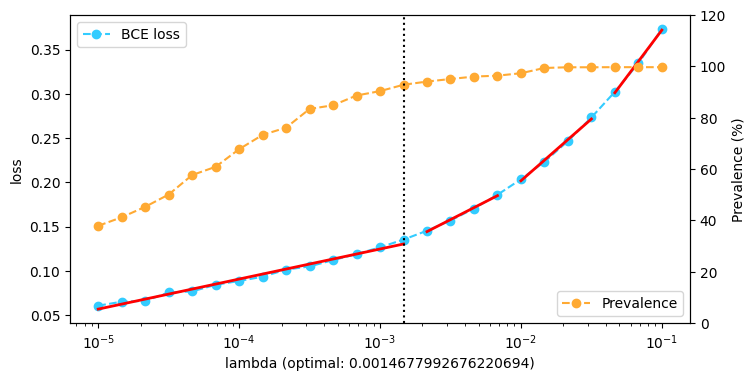

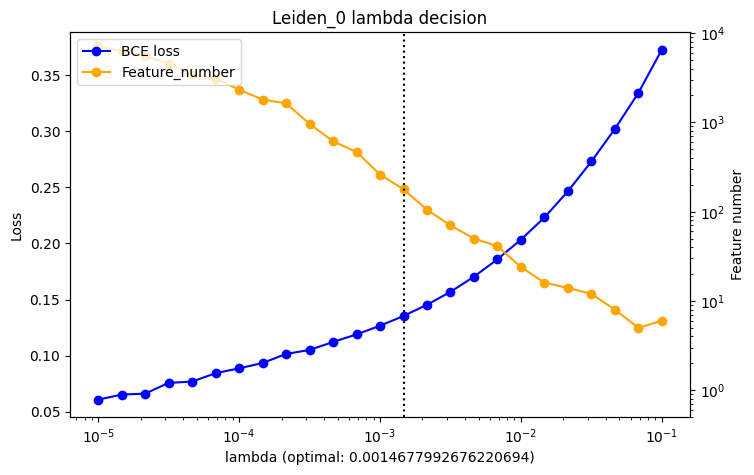

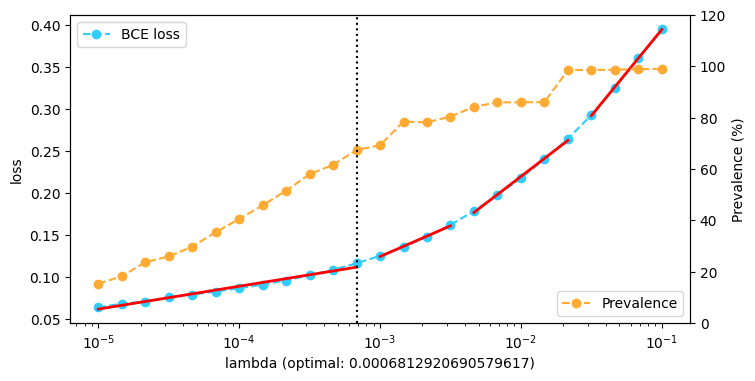

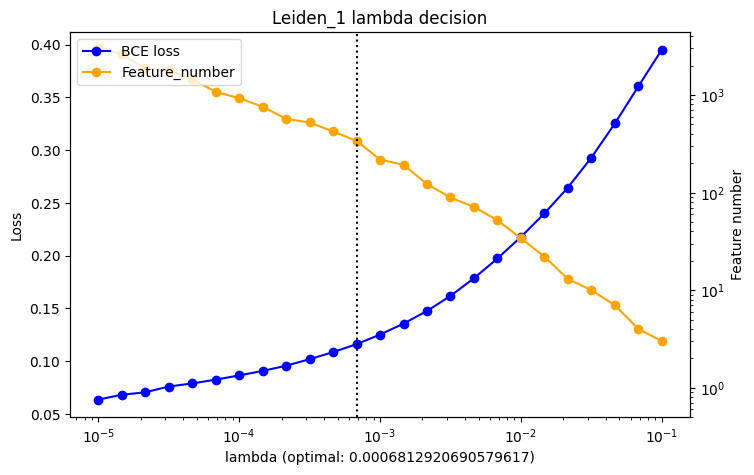

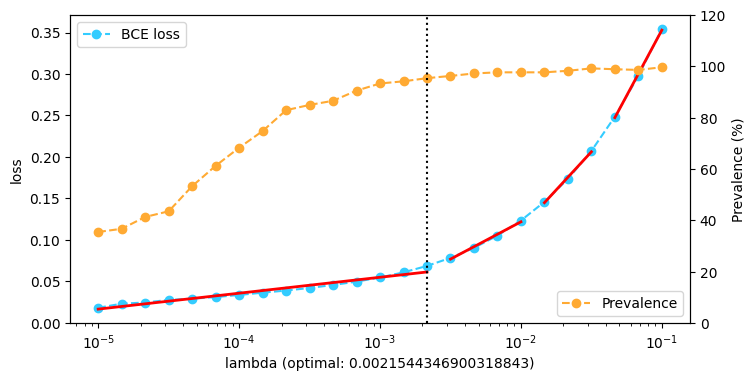

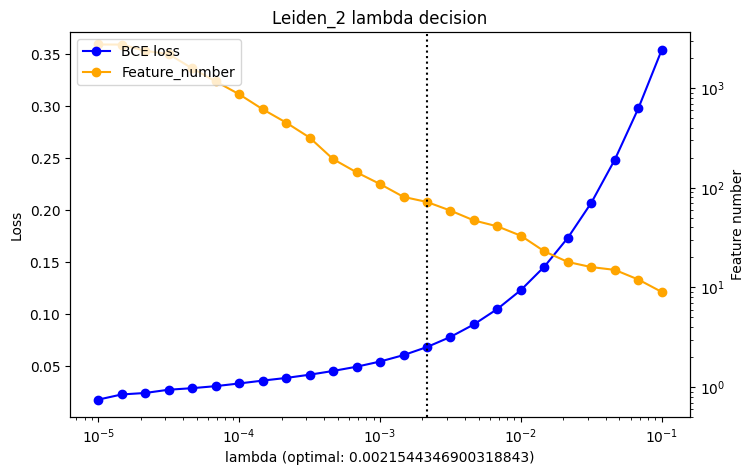

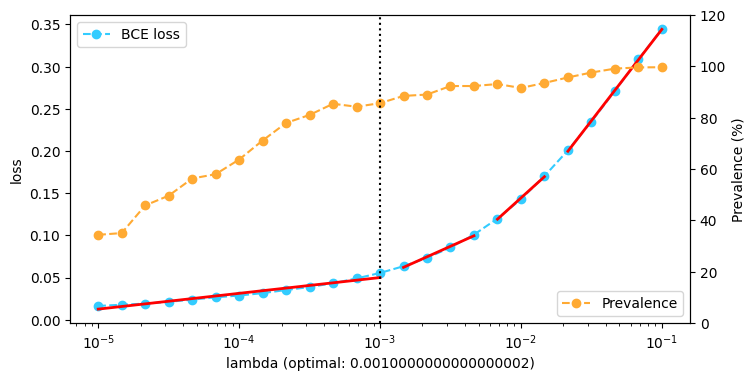

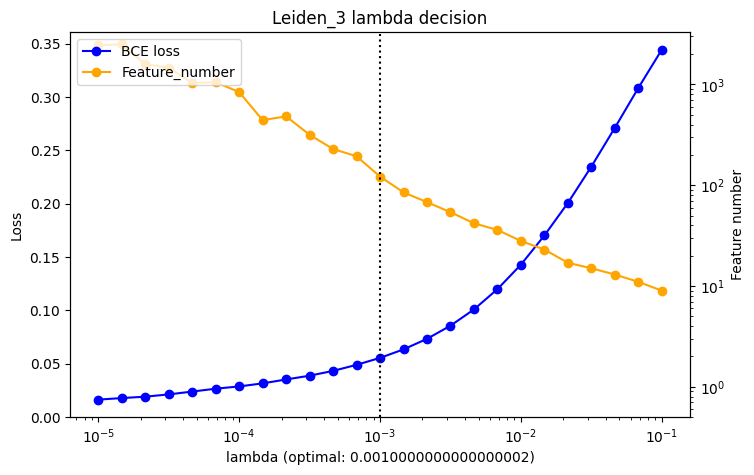

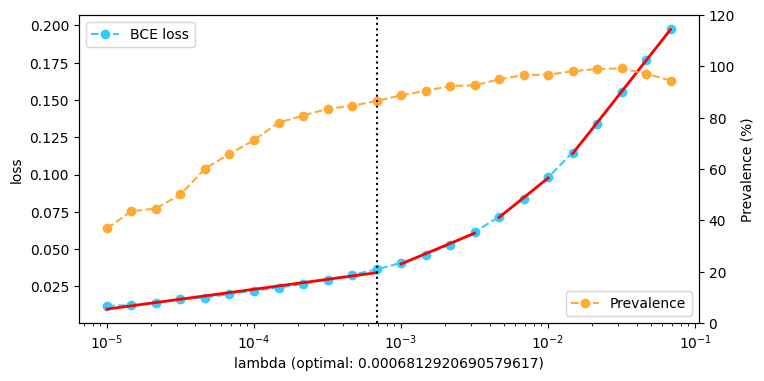

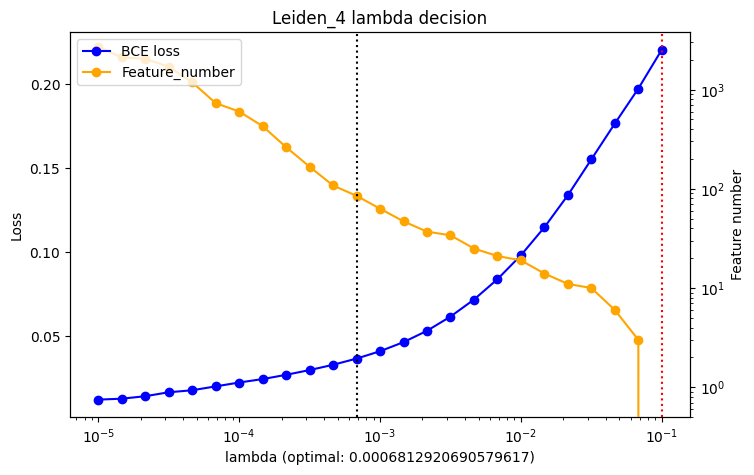

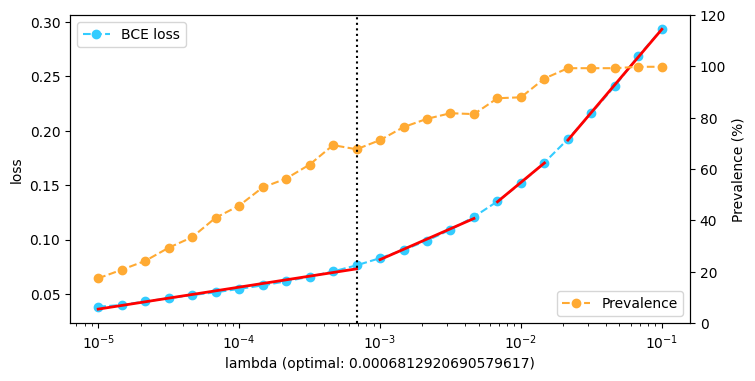

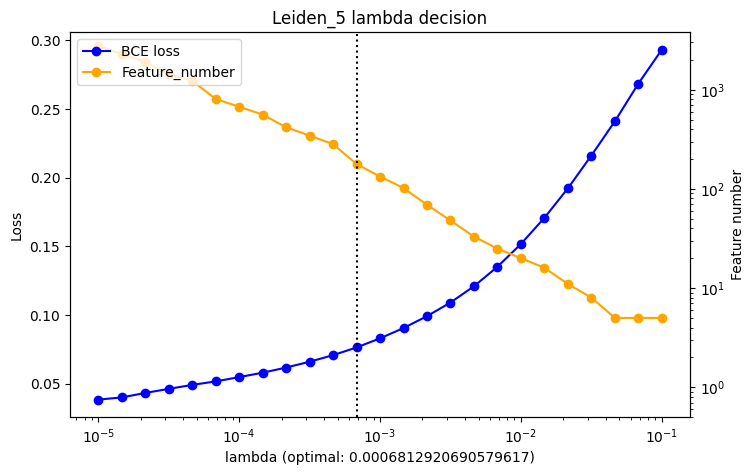

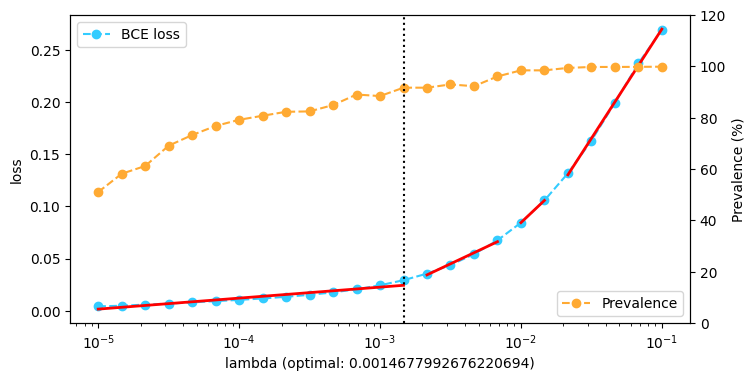

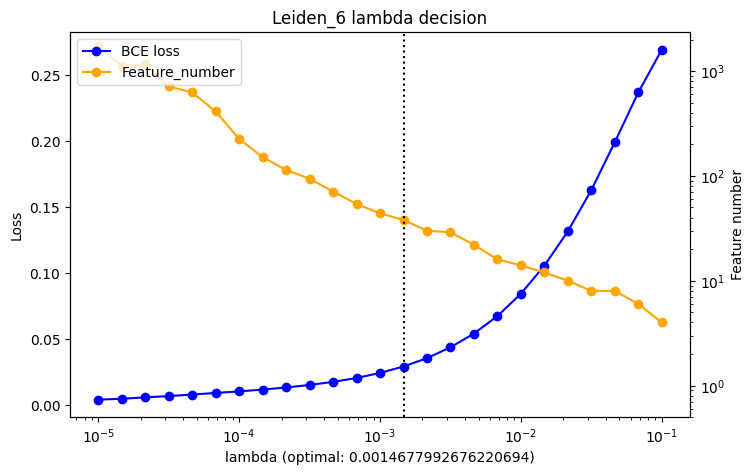

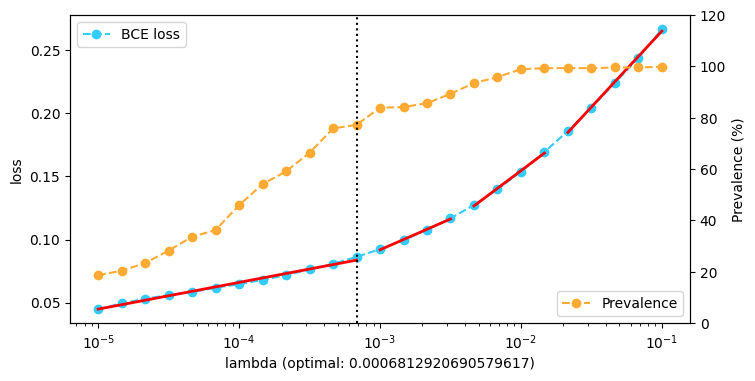

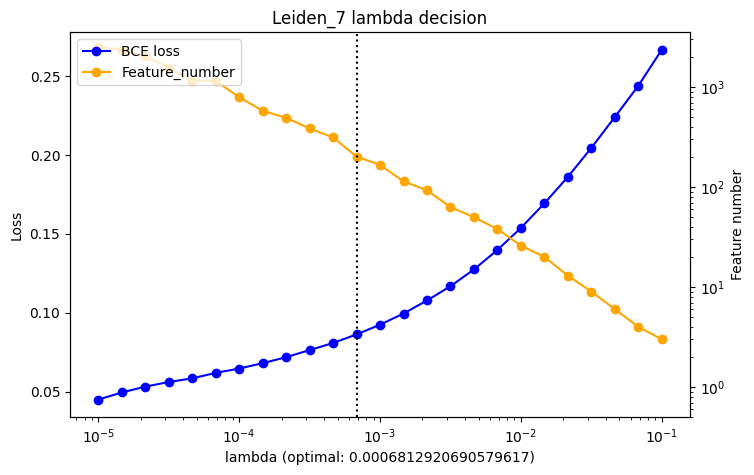

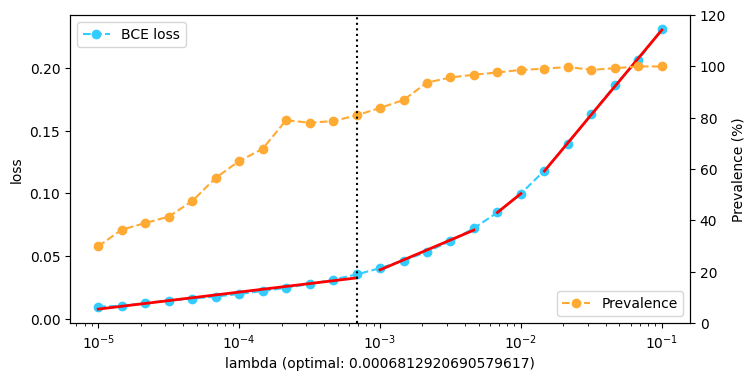

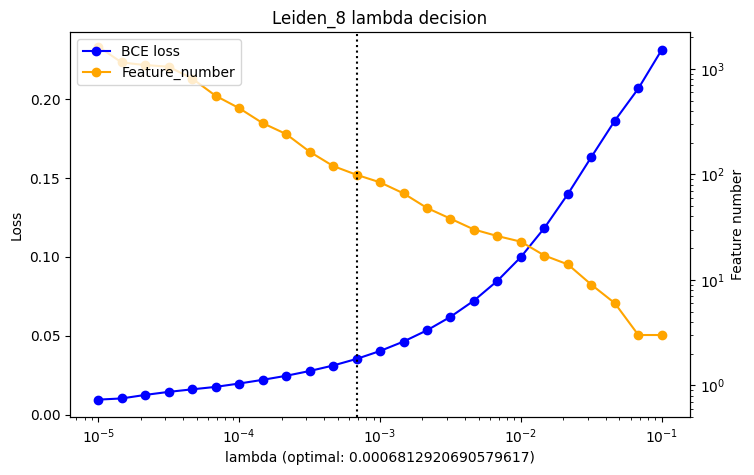

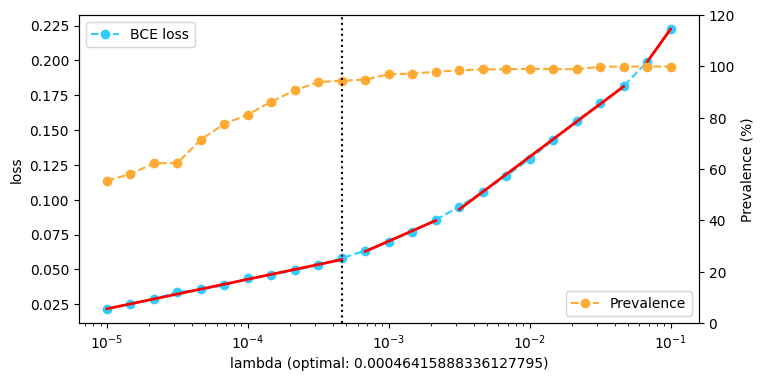

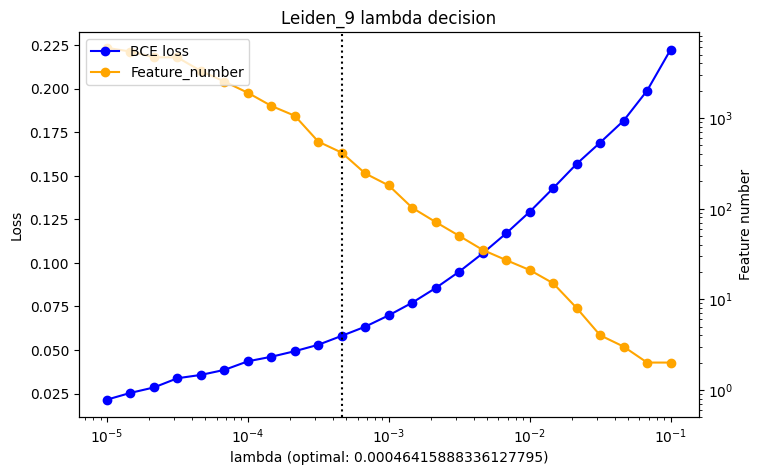

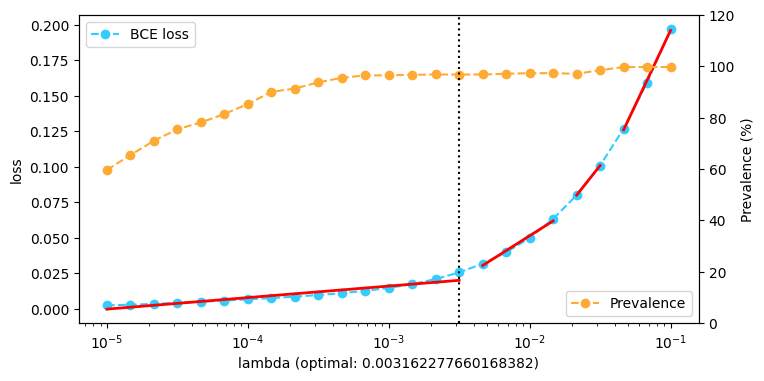

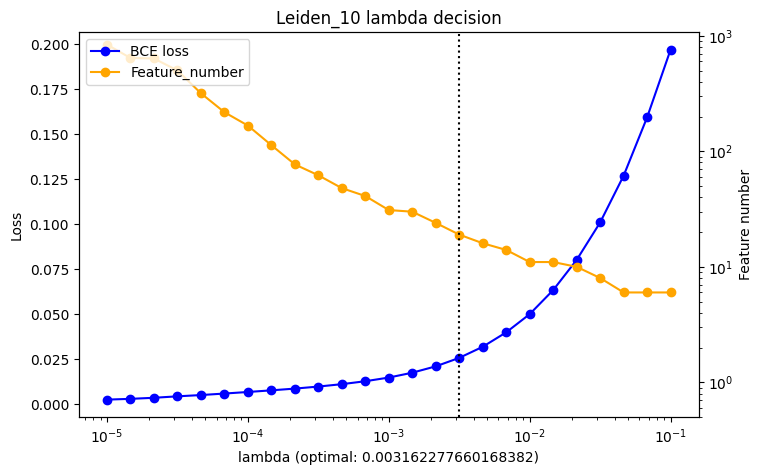

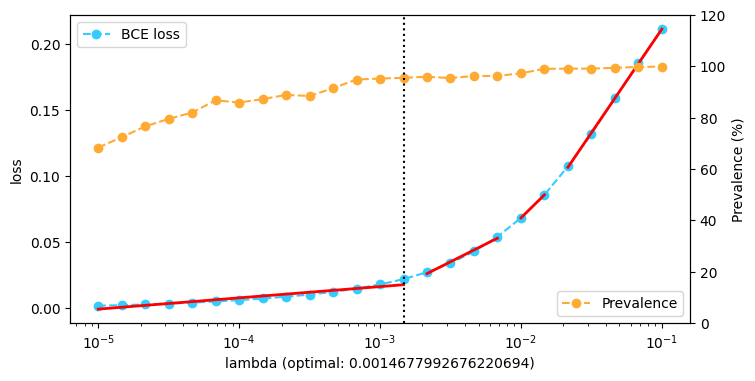

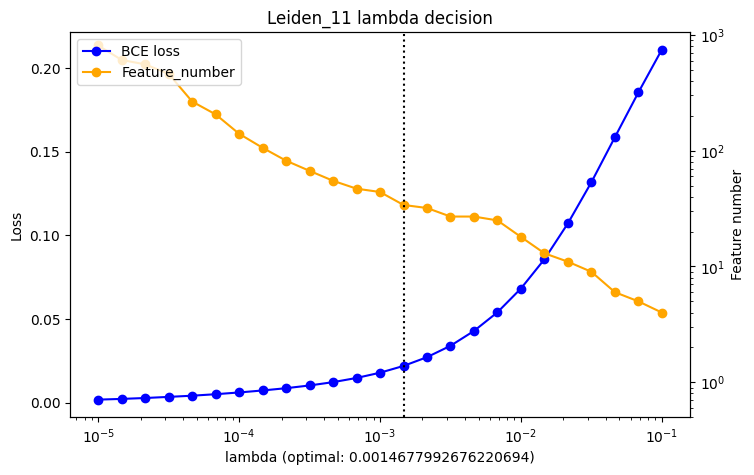

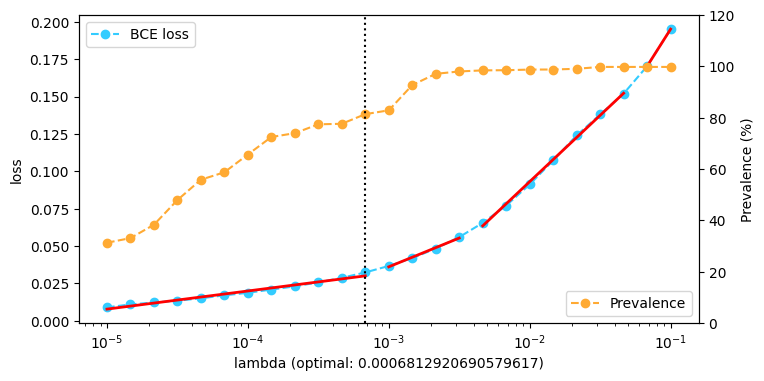

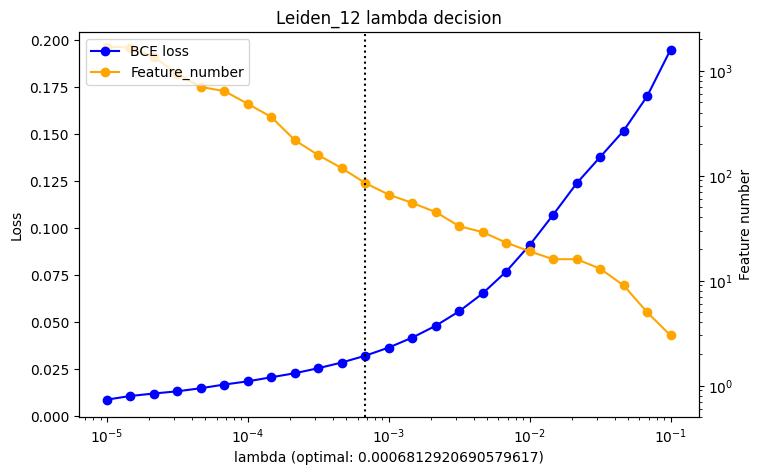

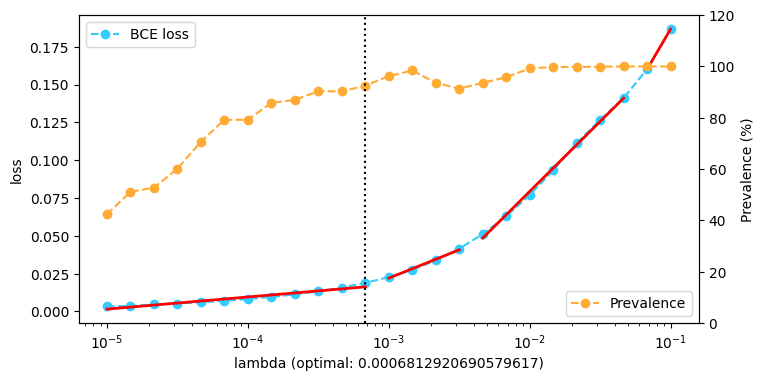

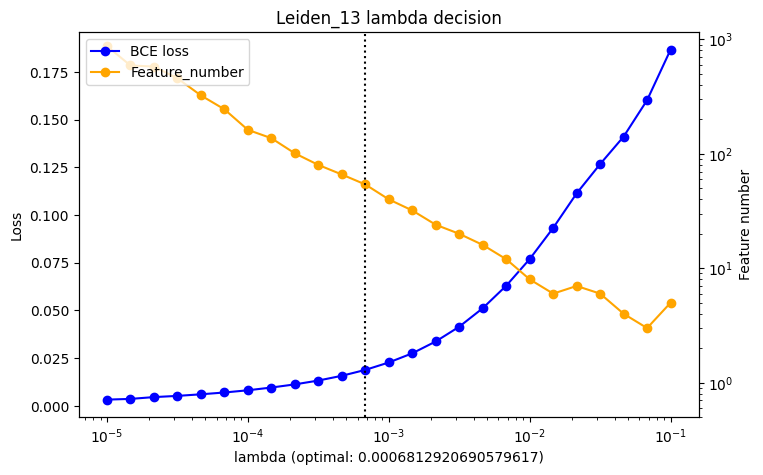

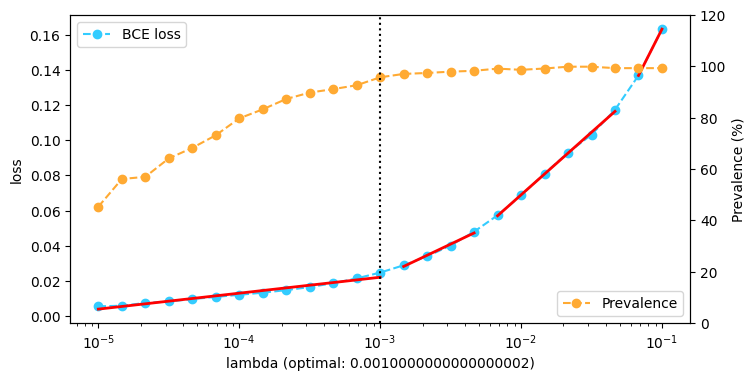

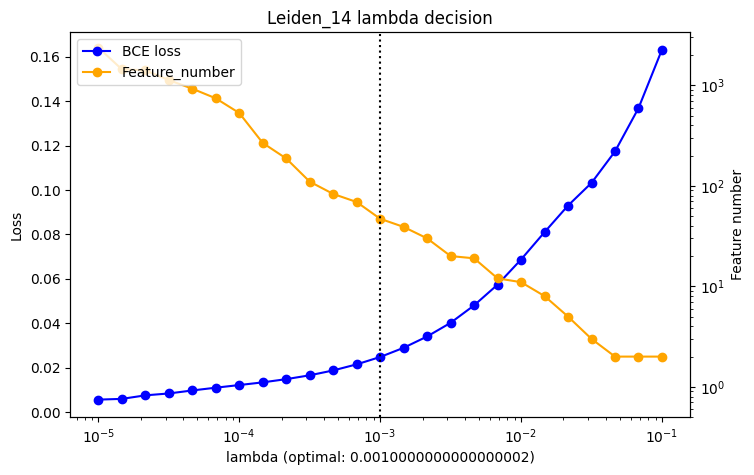

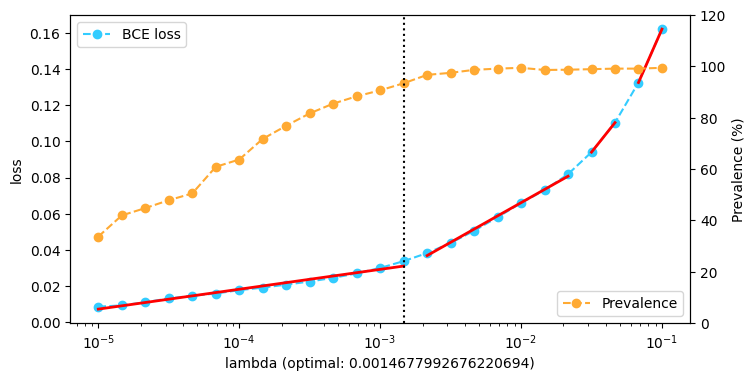

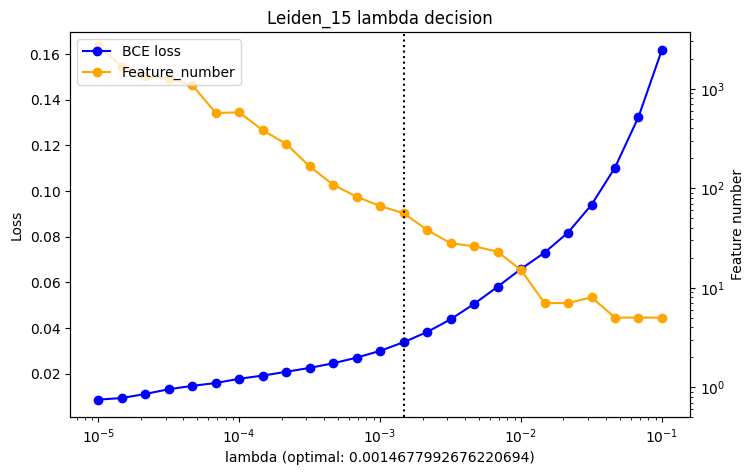

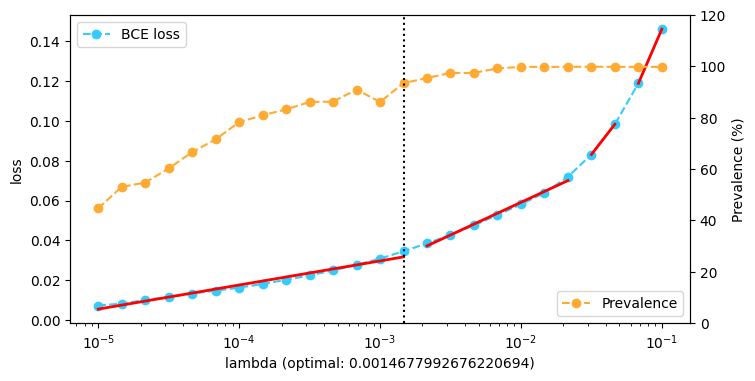

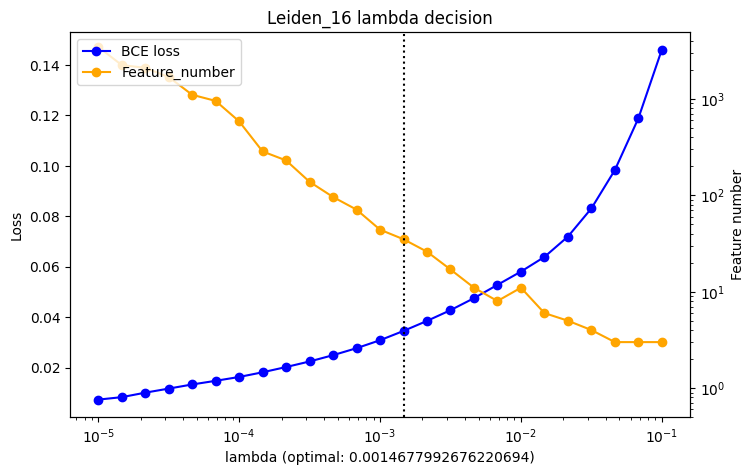

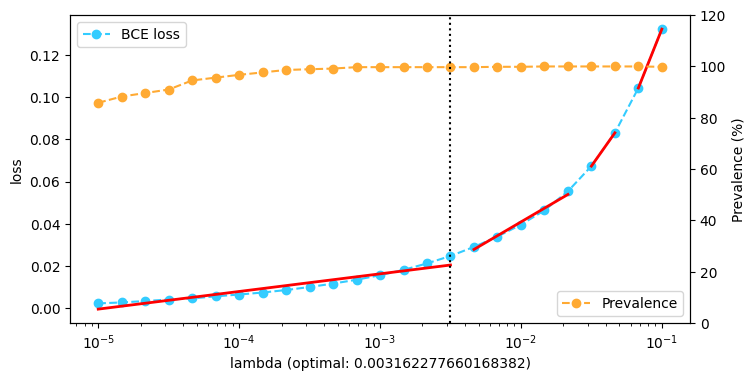

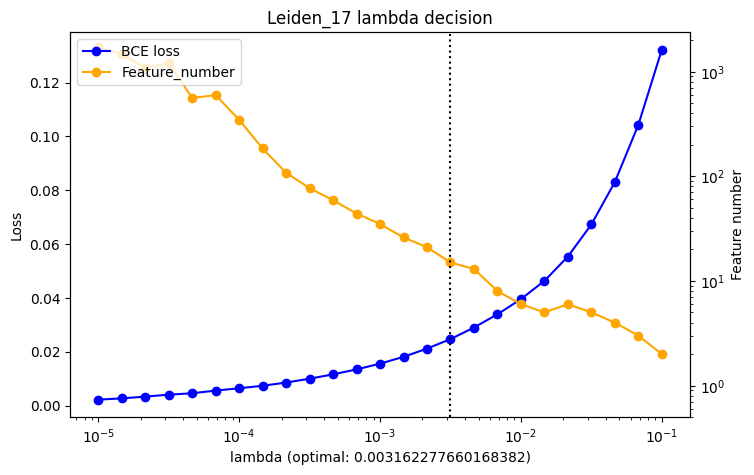

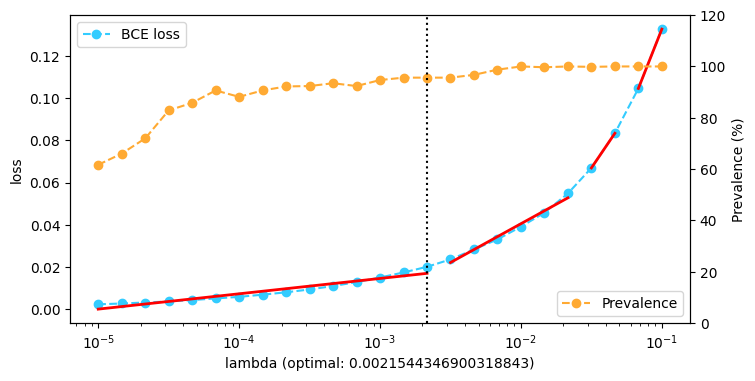

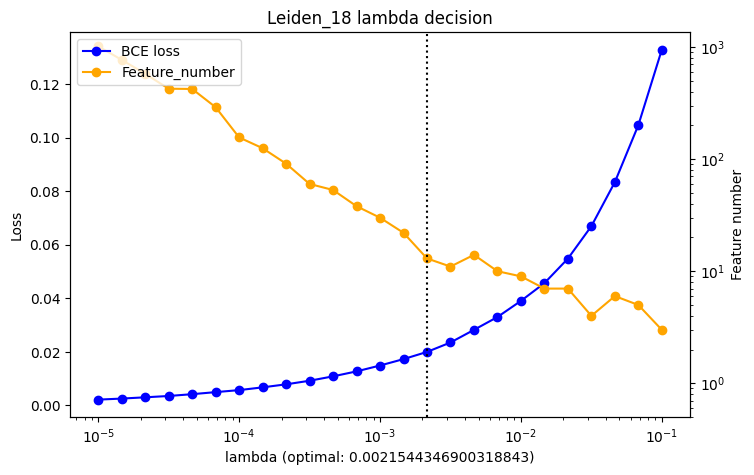

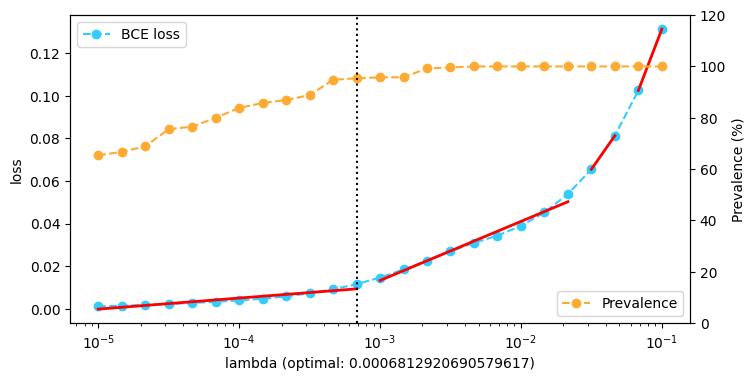

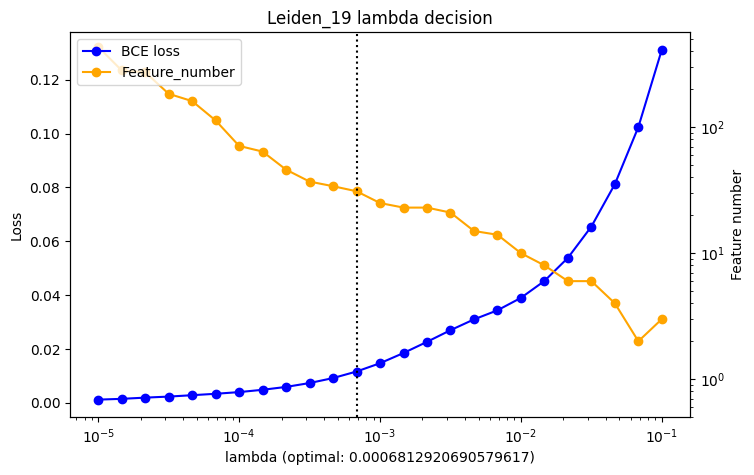

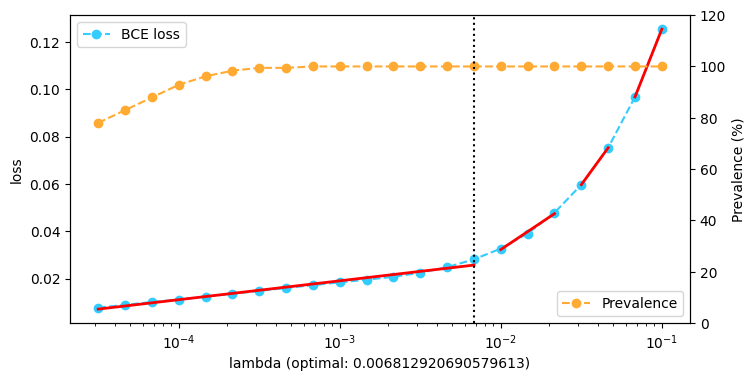

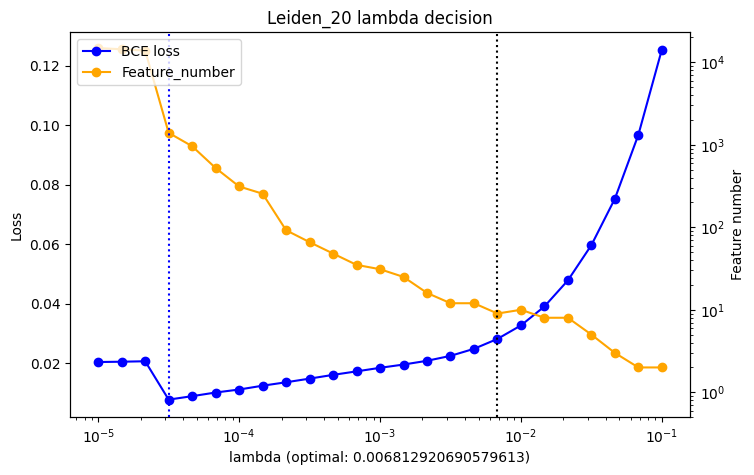

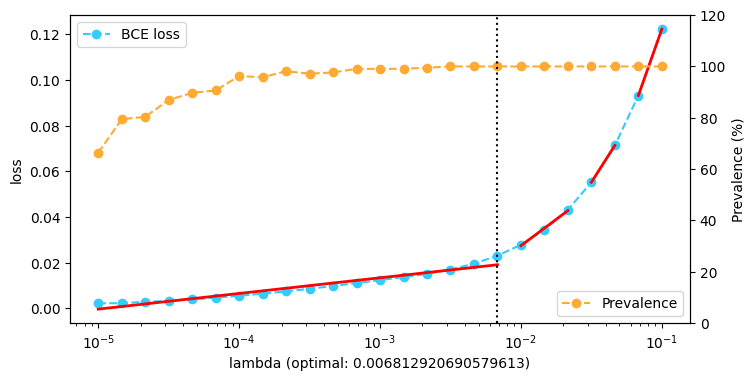

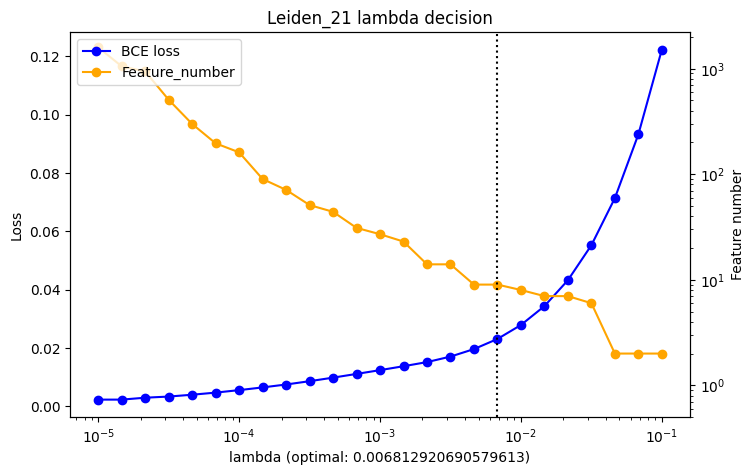

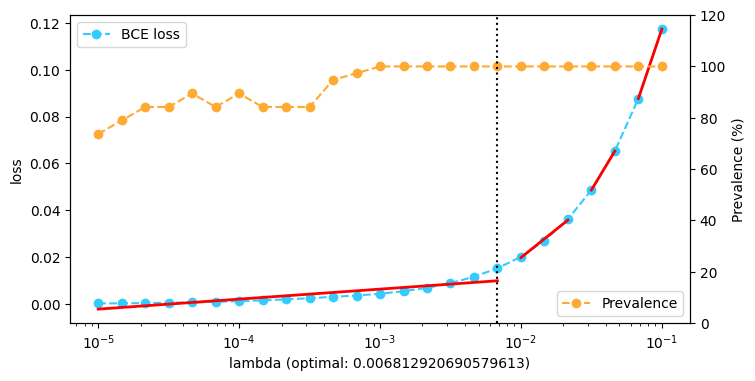

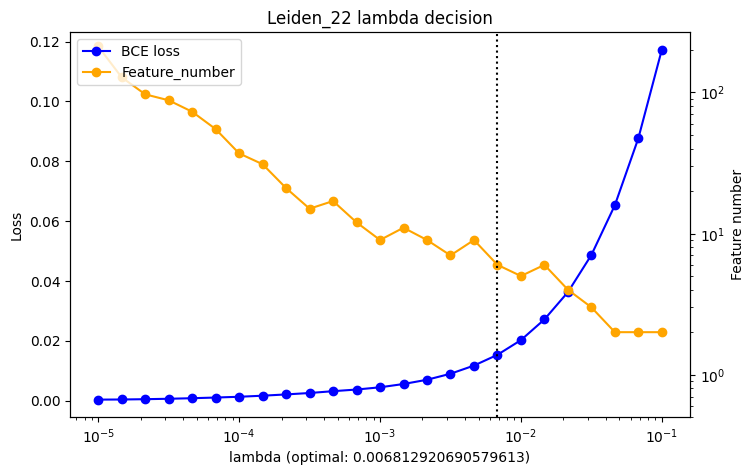

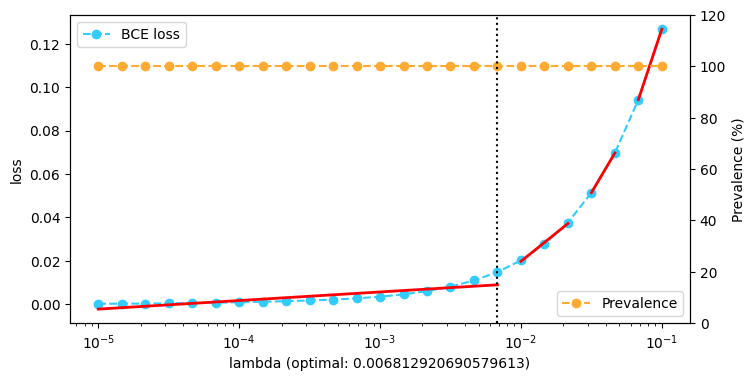

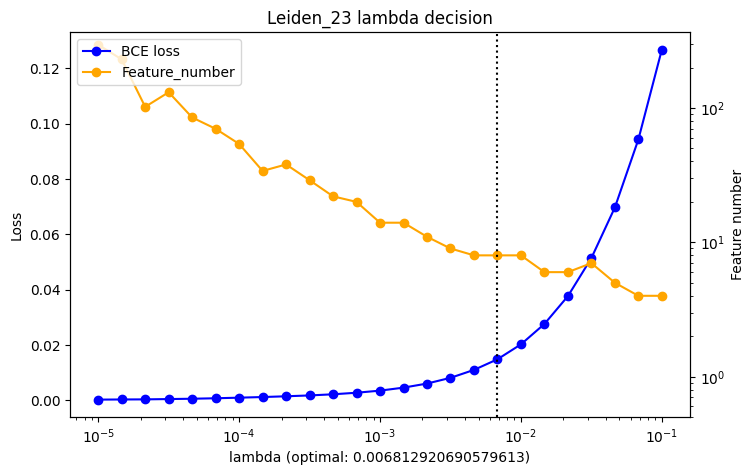

In [ ]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\HCC_case_study\tuning_leiden")
os.chdir(source_code_dir / 'HCC_case_study/tuning_leiden')

# Start index for each cell type
start_idx_dict = {
    'Leiden_20': 3
}
opt_lmbd_dict_k3 = {}
feature_no_dict_k3 = {}

# dir = home_path + 'EvanPys/Progress/PBMC_Hao_batch_noZ/Level1/lambda_decision/'
dir = r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\HCC_case_study\ldk4"
for celltype in queue:
    start_idx = start_idx_dict.get(celltype, 0)
    print('====================')
    print(celltype, 'Start index:', start_idx)
    # try:
    opt_lmbd_dict_k3[celltype], feature_no_dict_k3[celltype] = run_lmbd_decision(celltype, k_seg=4, start_idx=start_idx, output_dir=dir)
    # except:
    #     print('Skipping', celltype)

In [12]:
opt_lmbd_dict_k3

{'Leiden_0': 0.0014677992676220694,
 'Leiden_1': 0.0006812920690579617,
 'Leiden_2': 0.0021544346900318843,
 'Leiden_3': 0.0010000000000000002,
 'Leiden_4': 0.0006812920690579617,
 'Leiden_5': 0.0006812920690579617,
 'Leiden_6': 0.0014677992676220694,
 'Leiden_7': 0.0006812920690579617,
 'Leiden_8': 0.0006812920690579617,
 'Leiden_9': 0.00046415888336127795,
 'Leiden_10': 0.003162277660168382,
 'Leiden_11': 0.0014677992676220694,
 'Leiden_12': 0.0006812920690579617,
 'Leiden_13': 0.0006812920690579617,
 'Leiden_14': 0.0010000000000000002,
 'Leiden_15': 0.0014677992676220694,
 'Leiden_16': 0.0014677992676220694,
 'Leiden_17': 0.003162277660168382,
 'Leiden_18': 0.0021544346900318843,
 'Leiden_19': 0.0006812920690579617,
 'Leiden_20': 0.006812920690579613,
 'Leiden_21': 0.006812920690579613,
 'Leiden_22': 0.006812920690579613,
 'Leiden_23': 0.006812920690579613}

In [13]:
feature_no_dict_k3

{'Leiden_0': 178,
 'Leiden_1': 338,
 'Leiden_2': 72,
 'Leiden_3': 122,
 'Leiden_4': 85,
 'Leiden_5': 178,
 'Leiden_6': 38,
 'Leiden_7': 202,
 'Leiden_8': 99,
 'Leiden_9': 414,
 'Leiden_10': 19,
 'Leiden_11': 34,
 'Leiden_12': 85,
 'Leiden_13': 54,
 'Leiden_14': 47,
 'Leiden_15': 56,
 'Leiden_16': 35,
 'Leiden_17': 15,
 'Leiden_18': 13,
 'Leiden_19': 31,
 'Leiden_20': 9,
 'Leiden_21': 9,
 'Leiden_22': 6,
 'Leiden_23': 8}

In [4]:
# os.chdir(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\HCC_case_study')
os.chdir(source_code_dir / 'HCC_case_study')

In [ ]:
# with open('c_leiden_k3_opt_lmbd.json', 'w') as f:
#     json.dump(opt_lmbd_dict_k3, f)